# LUS-CS433

## 1. Code Exploration

### Imports

In [2]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import seaborn as sns

### Downloading data

## 2. Data Exploration

In [ ]:
diagnostics = pd.read_csv('labels_diagnostic.csv')

In [ ]:
# getting the list of names
!ls LUS\ images/negative > neg_names.csv
!ls LUS\ images/positive > pos_names.csv

neg = pd.read_csv('neg_names.csv', header=None)
pos = pd.read_csv('pos_names.csv', header=None)

data = neg.append(pos, ignore_index=True)
data

,0
0,100_QAID_1.png
1,100_QAID_2.png
2,100_QAIG_1.png
3,100_QAIG_2.png
4,100_QASD_1.png
...,...
3582,final_9_QPIG_2.png
3583,final_9_QPSD_1.png
3584,final_9_QPSD_2.png
3585,final_9_QPSG_1.png


In [ ]:
pos = pd.read_csv('pos_names.csv', header=None)

# removing .png extension
pos[0] = pos[0].apply(lambda x: x[:-4])

# extracting site
pos[0] = pos[0].apply(lambda x: x.split('_')[2])

pos

,0
0,QAID
1,QAID
2,QAIG
3,QAIG
4,QASD
...,...
2337,QPIG
2338,QPSD
2339,QPSD
2340,QPSG


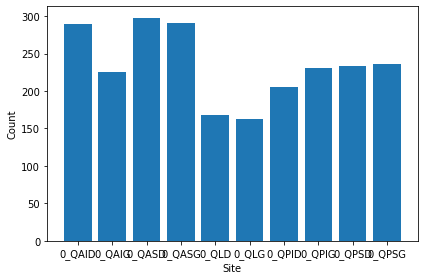

In [ ]:
sums = pd.get_dummies(pos).sum()

plt.bar(sums.index, sums.values)
plt.xlabel('Site')
plt.ylabel('Count')
plt.tight_layout()

## 3. Apply mask on Data and sort files

In [14]:
! mkdir data/LUS_proc_images
! mkdir data/LUS_proc_images/train
! mkdir data/LUS_proc_images/val
! mkdir data/LUS_proc_images/train/true
! mkdir data/LUS_proc_images/train/false
! mkdir data/LUS_proc_images/val/true
! mkdir data/LUS_proc_images/val/false 

In [10]:
x = cv2.imread('data/ppredictus_images/LUS images/negative/117_QAIG_1.png')

In [11]:
nb_rows, nb_cols, rgb = x.shape
nb_cols791 = 791
print(nb_rows, nb_cols)

1080 804


In [15]:
# TODO comment

#Create a mask for all images
mask804 = np.zeros([1080, 804,3])
for row in range(nb_rows):
    for col in range(nb_cols):
        if row > 25 and row < 1010 and col < 762 and (-4/5 * row) + 300 < col and (4/5 * row) + len(x[0])-300 > col:
            mask804[row, col] = [1,1,1]


In [118]:
mask791 = np.zeros([1080,791, 3])
for row in range(nb_rows):
    for col in range(nb_cols791):
        if row > 25 and row < 1010 and col < 762 and (-4/5 * row + 293) < col and (4/5*row) + len(x[0])-293 > col:
            mask791[row, col] = [1,1,1]

In [117]:
mask792 = np.zeros([1080,792, 3])
for row in range(nb_rows):
    for col in range(792):
        if row > 25 and row < 1010 and col < 762 and (-4/5 * row + 293) < col and (4/5*row) + len(x[0])-293 > col:
            mask792[row, col] = [1,1,1]

In [39]:
import glob
def create_samples(num_samples, ratio, path):
    images_path = glob.glob(path)
    train = int(num_samples * ratio)

    for i, image in enumerate(images_path[:num_samples]):
        cv2_img = cv2.imread(image)

        if (len(cv2_img[0]) == 791):
            masked_img = cv2_img * mask791
        else:
            masked_img = cv2_img * mask804
        
        # Selecting image name from path name
        im_name = image.split("/")[-1]
        
        if i >= train:
            cv2.imwrite(f"data/LUS_proc_images/val/true/{im_name}", masked_img)
        else:
            cv2.imwrite(f"data/LUS_proc_images/train/true/{im_name}", masked_img)

In [40]:
#Make sure that the files are empty
! rm -rfv data/LUS_proc_images/val/true/*
! rm -rfv data/LUS_proc_images/train/true/*

In [41]:
#Generates the samples!
num_samples = 1245
ratio = 0.8
path = "data/ppredictus_images/LUS images/negative/*.png"
create_samples(num_samples, ratio, path)

#### Compute mean brightness over all sample

In [42]:
def create_brightness_df(path):
    df = pd.DataFrame(columns = ['mean', 'std'])
    images_path = glob.glob(path)
    
    for i,image in enumerate(images_path):
        img = cv2.imread(image)
        m, s = cv2.meanStdDev(img)
        df.loc[i] = [m[0,0], s[0,0]]
        
    return df

In [43]:
df = create_brightness_df("data/LUS_proc_images/train/true/*.png")

<AxesSubplot:>

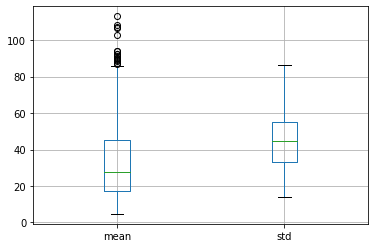

In [44]:
df.boxplot()

<AxesSubplot:>

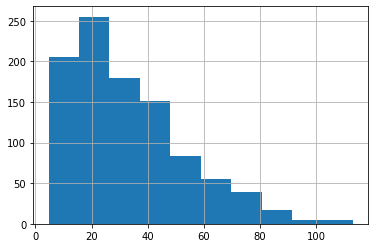

In [45]:
df['mean'].hist()

<AxesSubplot:>

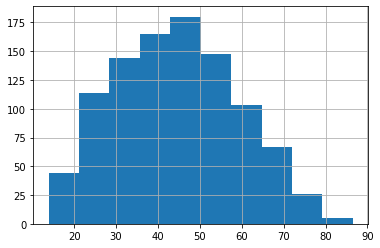

In [46]:
df['std'].hist()

<AxesSubplot:xlabel='std', ylabel='mean'>

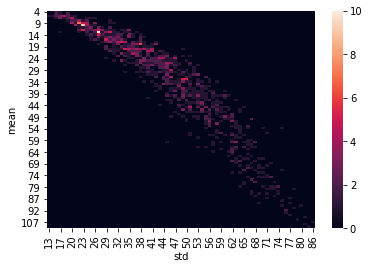

In [47]:
df2 = df.astype(int)
df2 = pd.crosstab(df2['mean'], df2['std'])
sns.heatmap(df2)

In [131]:
# TODO comment
def split_video(video_path):
    video = cv2.VideoCapture(video_path)
    i = 0
    df_video = pd.DataFrame(columns = ['mean', 'std'])
    while(video.isOpened()):
        ret, image = video.read()
        if ret == True:
            video.set(cv2.CAP_PROP_POS_MSEC,(i*1000))
            if len(image[0]) == 791:
                image = image * mask791
            elif len(image[0]) == 804:
                image = image * mask804
            elif len(image[0]) == 792:
                image = image * mask792
            else:
                i += 1
                continue
            m, s = cv2.meanStdDev(image)
            df_video.loc[i] = [m[0,0], s[0,0]]
            i += 1
        else:
            break
    video.release()
    return df_video

In [132]:
"""# Renaming to appropriate format
def replace_dot_by_underscore(path):
    path_list = glob.glob(path)
    
    for old_path in path_list:
        new_path = old_path.replace(".", "_", 1)
        os.rename(old_path, new_path)
        
replace_dot_by_underscore("data/Ultrason butterflynetwork/*")"""

'# Renaming to appropriate format\ndef replace_dot_by_underscore(path):\n    path_list = glob.glob(path)\n    \n    for old_path in path_list:\n        new_path = old_path.replace(".", "_", 1)\n        os.rename(old_path, new_path)\n        \nreplace_dot_by_underscore("data/Ultrason butterflynetwork/*")'

In [125]:
df_split = split_video("data/Ultrason butterflynetwork/1_1_QAID_1.mp4")

In [134]:
df_split = split_video("data/Ultrason butterflynetwork/1_9_QLD.mp4")

In [135]:
df_video2 = df_video.astype(int)
df_video2 = pd.crosstab(df_video2['mean'], df_video2['std'])
sns.heatmap(df_video2)

ValueError: zero-size array to reduction operation fmin which has no identity

Trying to regroup all formats used

In [149]:
butterfly_img_path = glob.glob("data/Ultrason butterflynetwork/*.png")
lus_neg_img_path = glob.glob("data/ppredictus_images/LUS images/negative/*.png")
vid_img_path = glob.glob("data/Ultrason butterflynetwork/*.mp4")

def count_formats(path_list):
    counts = {}
    for path in path_list: 
        key = cv2.imread(path).shape
        if key not in counts.keys():
            counts[key] = 0
        else:
            counts[key] = counts[key] + 1
    return counts

def count_formats_vid(path_list):
    counts = {}
    for path in path_list:
        video = cv2.VideoCapture(path)
        success, img = video.read()
        
        if success == False :
            raise("Exception nulle")
        
        key = img.shape
        video.release()
        if key not in counts.keys():
            counts[key] = 0
        else:
            counts[key] = counts[key] + 1
    return counts

In [ ]:
butterfly_img_formats = count_formats(butterfly_img_path)
lus_neg_img_formats = count_formats(lus_neg_img_path)
vid_formats = count_formats_vid(vid_img_path)

In [152]:
print(butterfly_img_formats)
print(lus_neg_img_formats)
print(vid_formats)

{(1080, 791, 3): 3453, (1080, 790, 3): 2}
{(1080, 804, 3): 1152, (1080, 791, 3): 91}
{(1080, 792, 3): 1265}
